# Preparation

## Step 1 - Training Data

Gather a bunch of Finnish words and Google Translate them to English (dictionary would be even better). 

In [1]:
import codecs
eng=list(map(unicode.strip,codecs.open("eng_5k.txt","r","utf-8")))
fi=list(map(unicode.strip,codecs.open("fin_5k.txt","r","utf-8")))
print "Top 20 and bottom 20, straight from Google Translate"
for e,f in zip(eng[:20]+eng[-20:],fi[:20]+fi[-20:]):
    print f, "<-->", e
    

Top 20 and bottom 20, straight from Google Translate
ja <--> and
ei <--> No
tämä <--> this
voida <--> be
saada <--> get
kun <--> when
minä <--> I
kaikki <--> all
vuosi <--> year
muu <--> other
pitää <--> keep
nyt <--> now
sekä <--> mixed
jo <--> already
sitten <--> then
toinen <--> second
asia <--> thing
käyttää <--> use
sinä <--> you
ottaa <--> take
käyttökokemus <--> User experience
fanittaa <--> legions of fans
Oskari <--> Oskari
kallo <--> skull
helliä <--> cherish
Kaarle <--> Charles
isosisko <--> big sister
päihittää <--> outdo
nimenhuuto <--> roll call
kiusa <--> nuisance
hyväntuulinen <--> good-humored
Johnny <--> Johnny
kilpailuetu <--> competitive
huoliaihe <--> worry topic
päivätä <--> date
Amanda <--> Amanda
kyynärpää <--> elbow
guru <--> guru
kotiin <--> home
ilmoitella <--> placard


## Step 2 - Turn words to vectors

A look-up in a ready-made list.

In [3]:
import lwvlib
#Finnish (lemma) and English models, load first 100K words by occurrence count
finwv=lwvlib.load("pb34_lemma_200_v2.bin",100000,100000)
engwv=lwvlib.load("GoogleNews-vectors-negative300.bin",100000,100000)

#The code below is just a technical code to gather the positions
#in vocabulary of the words which correspond to each other
#we need both the source and the translation word to be in the models
fin_rows=[]
eng_rows=[]
for i,(w_fi,w_en) in enumerate(zip(fi,eng)):
    k_fin=finwv.get(w_fi)
    k_eng=engwv.get(w_en)
    if k_fin and k_eng:
        fin_rows.append(k_fin)
        eng_rows.append(k_eng)

train_fin=finwv.vectors[fin_rows]
train_eng=engwv.vectors[eng_rows]
print "Learning on",len(fin_rows),"Finnish-English word pairs"

Learning on 3416 Finnish-English word pairs


In [4]:
# Machine learning mambo jambo, takes few minutes to run
from keras.models import Sequential
from keras.layers.core import Dense, Activation

dim_in,dim_internal,dim_out=train_fin.shape[1],200,train_eng.shape[1]

#Neural network:
model = Sequential()
#Non-linear layer #1
model.add(Dense(dim_internal, input_dim=dim_in))
model.add(Activation("tanh"))
#Non-linear layer #2, because why not :)
model.add(Dense(dim_internal))
model.add(Activation("tanh"))
#Linear projection at the end
model.add(Dense(dim_out))

#Learn!
model.compile(loss='mse', optimizer='Adadelta')
model.fit(train_fin,train_eng,verbose=0,batch_size=200)


Using Theano backend.
/usr/local/lib/python2.7/dist-packages/Theano-0.8.0rc1-py2.7.egg/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


Now we have learned to map from the Finnish space into the English space. It only took few minutes. Does it then work? Let's see!

In [11]:
#This code below does the translation using
#the model we learned before
import numpy

def fin2eng(word,N=5):
    x=finwv.get(w)
    if not x:
        return u"not-in-top-100K-words"
    vec=finwv.vectors[x]
    vec=vec.reshape((1,dim_in))
    vec_transl=model.predict(vec)
    vec_transl/=numpy.linalg.norm(x=vec_transl,ord=None)
    sims=vec_transl.dot(engwv.vectors.T)
    sims=(sims/engwv.norm_constants)[0]
    translations= sorted(((sims[idx],engwv.words[idx]) \
              for idx in numpy.argpartition(sims,-N-1)[-N-1:]), reverse=True)[1:]
    return u", ".join(w for sim,w in translations)

finnish_lemmas=u"maha#haava,julma,epä#reilu,koira,viini,oksennus,vahvistin,läppäri,\
ikkuna,kuolema,pylly,sohva,maito,epä#toivoinen,iloinen,lentäjä,kolaroida,\
masennus,mania,hymy,viina,kuolla,juoda,syödä"
for w in finnish_lemmas.split(u","):
    print w, u"-->", fin2eng(w)

maha#haava --> bacterial_infection, liver, diarrhea, allergic_reaction, asthma
julma --> wicked, savage, brutal, loathsome, vicious
epä#reilu --> foolish, ridiculous, silly, hypocritical, absurd
koira --> dog, cat, puppy, dad, mother
viini --> tasting, chocolate, gourmet, wines, delicious
oksennus --> puke, flatulence, vomiting, stinking, stink
vahvistin --> stereo, subwoofer, amplifiers, hi_fi, stereo_speakers
läppäri --> handset, projector, netbook, gadget, smartphone
ikkuna --> window, porch, roof, skylight, front_porch
kuolema --> life, earthly, perish, salvation, remarry
pylly --> bum, ass, thighs, chin, forehead
sohva --> sofa, downstairs, bed, bathroom, tub
maito --> buttermilk, apple_juice, chocolate, yogurt, cow_milk
epä#toivoinen --> terrible, desperate, mad, horrible, foolish
iloinen --> wonderful, lovely, happy, nice, cheerful
lentäjä --> fighter_pilot, paratrooper, policeman, stuntman, sailor
kolaroida --> accident, wreck, crash, fatal, mishap
masennus --> depression, chro

# Damn! Those are not bad!

Let's have a look at the spaces before and after mapping to see what's going on.


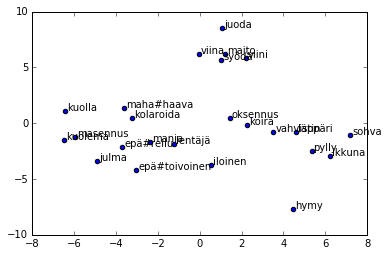

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.decomposition

words,word_indices=[],[]
for w in finnish_lemmas.split(u","):
    x=finwv.get(w)
    if not x:
        continue
    words.append(w)
    word_indices.append(x)
vectors=finwv.vectors[word_indices]
#make them two-dimensional with PCA
pca2=sklearn.decomposition.PCA(2)
fin_vectors2d=pca2.fit_transform(vectors)
plt.scatter(fin_vectors2d[:,0],fin_vectors2d[:,1])
for widx,w in enumerate(words):
    plt.annotate(s=w,xy=fin_vectors2d[widx],xytext=fin_vectors2d[widx]+(0.1,0.05))